## Cellposesam (cellpose 4) 

In [1]:
# First, test if environment is working correctly by checking versions
import torch
import numpy as np

print("Torch version:", torch.__version__)
print("NumPy version:", np.__version__)

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

print("cuDNN available:", torch.backends.cudnn.is_available())
print("cuDNN version:", torch.backends.cudnn.version())

Torch version: 2.6.0
NumPy version: 1.26.4
CUDA available: True
GPU name: NVIDIA GeForce RTX 3090
cuDNN available: True
cuDNN version: 90800


## Import cellpose

... and check major version.  Version 4 is the sam version.  Earlier versions are built on unets. 

In [2]:
import cellpose
import numpy as np
import os
import matplotlib.pyplot as plt
from cellpose import models, io

major_number = cellpose.version.split('.')[0]
print(f"Cellpose version: {cellpose.version} (major number: {major_number})")

if major_number == '3':
    model = models.Cellpose(gpu=True, model_type='cyto2')
elif major_number == '4':
    model = models.CellposeModel(gpu=True)


Cellpose version: 3.1.0 (major number: 3)


## Load and display example image

MAX_C6M4_big.lif - TileScan_003_Merging001_Crop001-1
Loaded image shape: (1091, 1365, 3), dtype: uint8


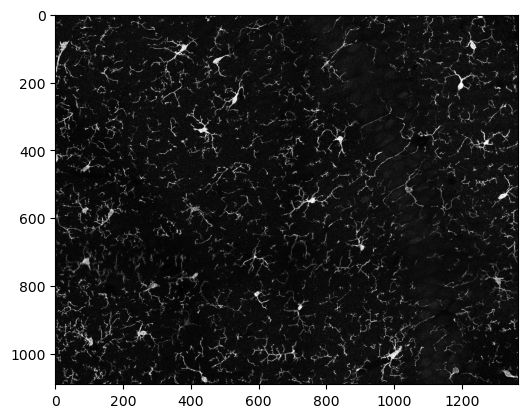

In [3]:
image_path = r"D:\images\tnia-python-images\imagesc\2025_11_21_stellate\MAX_C6M4_big.lif - TileScan_003_Merging001_Crop001-1.tif"

image_name = os.path.basename(image_path)
image_name = os.path.splitext(image_name)[0]
print(image_name)

img = io.imread(image_path)

if (len(img.shape) == 2):
    img = np.expand_dims(img, axis=2)  # Add channel dimension if it's grayscale
    # repeat channels so there is 3
    img = np.repeat(img, 3, axis=2)
# Print image information
print(f"Loaded image shape: {img.shape}, dtype: {img.dtype}")

plt.imshow(img)

## Run cellpose

In [4]:
img.shape, img.dtype, img.min(), img.max()
img = img//2 + 10

In [5]:
result = model.eval(img, niter=200)

## Plot ground truth and cellpose results overlays. 

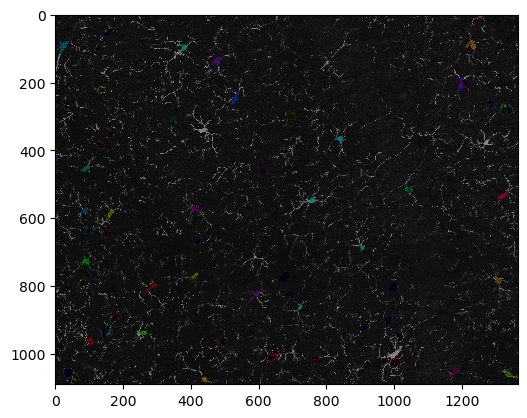

In [6]:
from tnia.plotting.plt_helper import mask_overlay

result_overlay = mask_overlay(img, result[0])

plt.imshow(result_overlay)

## Fix saturated pixels by adding random noise

Create a fake way to remove saturation by replacing saturated pixels (value 255) with random high values.

Original image stats - Min: 0, Max: 255, Shape: (1091, 1365, 3)
Found 166101 saturated pixels (3.72% of image)
Replaced saturated pixels with random values between 50-254
Fixed image stats - Min: 0, Max: 127


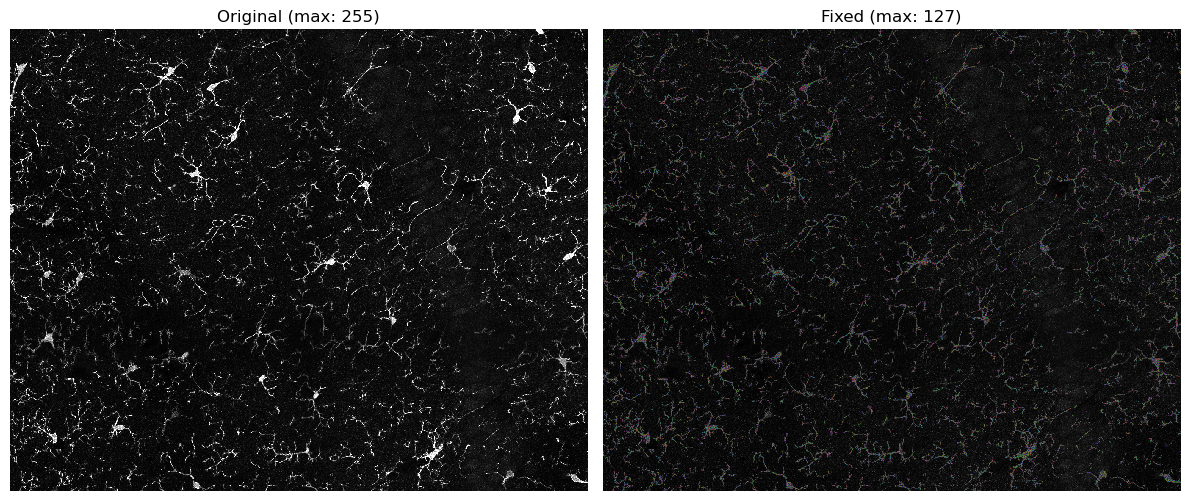

In [7]:
def fix_saturated_pixels(image, saturation_value=255, high_range_min=200, high_range_max=254):
    """
    Replace saturated pixels with random high values to simulate non-saturated appearance.
    
    Parameters:
    - image: input image array
    - saturation_value: pixel value considered saturated (default 255)
    - high_range_min: minimum replacement value (default 200)
    - high_range_max: maximum replacement value (default 254)
    """
    # Work with a copy to avoid modifying original
    fixed_img = image.copy()
    
    # Find saturated pixels
    saturated_mask = (image > saturation_value)
    
    # Count saturated pixels
    num_saturated = np.sum(saturated_mask)
    print(f"Found {num_saturated} saturated pixels ({num_saturated/image.size*100:.2f}% of image)")
    
    if num_saturated > 0:
        # Generate random values in high range for saturated pixels
        random_values = np.random.randint(high_range_min, high_range_max + 1, size=num_saturated)
        
        # Replace saturated pixels with random high values
        fixed_img[saturated_mask] = random_values//2
        
        print(f"Replaced saturated pixels with random values between {high_range_min}-{high_range_max}")
    
    return fixed_img

# Load original image again for processing
img_original = io.imread(image_path)

if (len(img_original.shape) == 2):
    img_original = np.expand_dims(img_original, axis=2)
    img_original = np.repeat(img_original, 3, axis=2)

print(f"Original image stats - Min: {img_original.min()}, Max: {img_original.max()}, Shape: {img_original.shape}")

# Fix saturated pixels
img_fixed = fix_saturated_pixels(img_original, saturation_value=100, high_range_min=50, high_range_max=254)

print(f"Fixed image stats - Min: {img_fixed.min()}, Max: {img_fixed.max()}")

# Compare before/after
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(img_original)
axes[0].set_title(f'Original (max: {img_original.max()})')
axes[0].axis('off')

axes[1].imshow(img_fixed)  
axes[1].set_title(f'Fixed (max: {img_fixed.max()})')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Running cellpose on fixed (non-saturated) image...


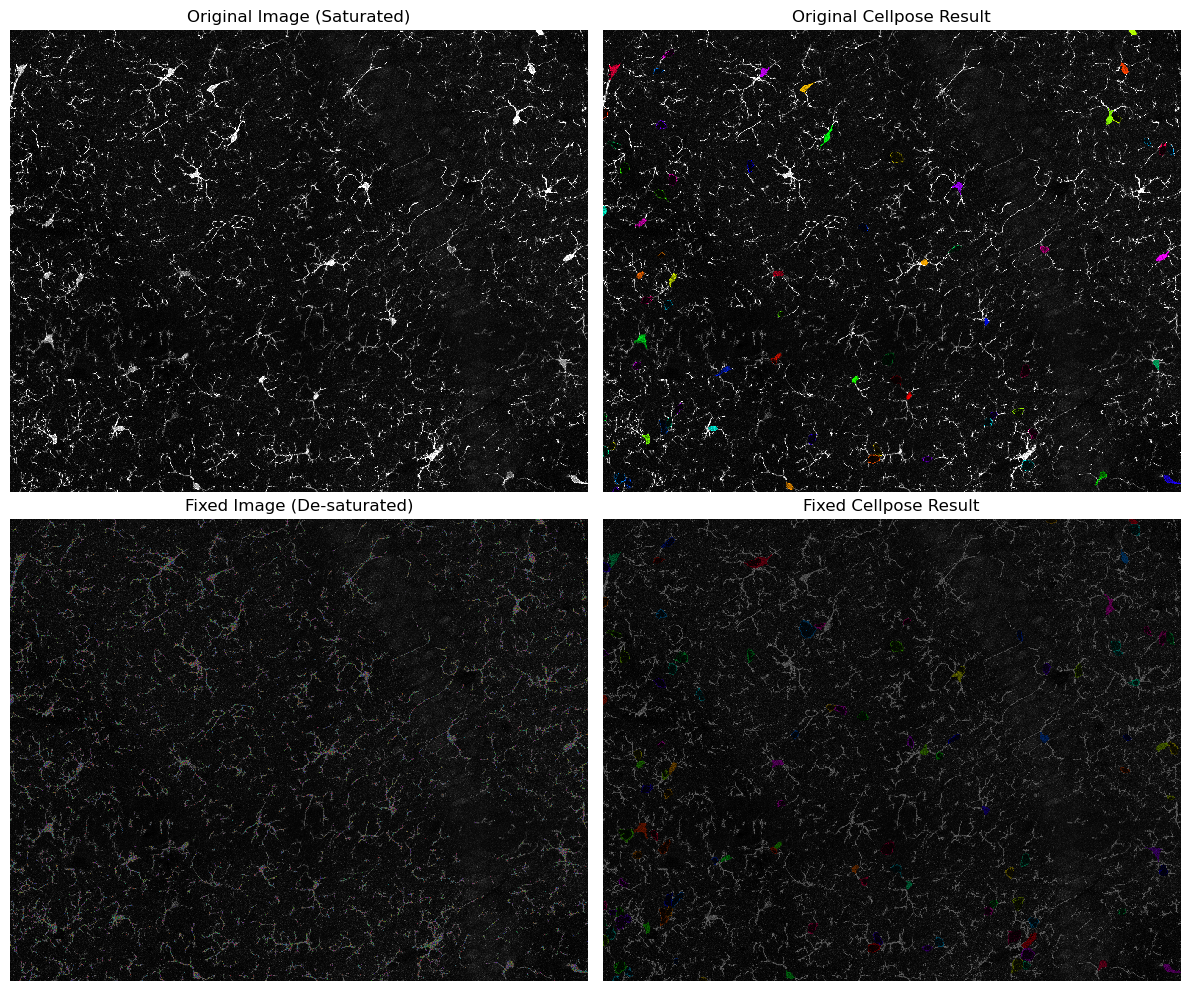

Original result: 71 objects detected
Fixed result: 115 objects detected


In [8]:
# Now run cellpose on the fixed image
print("Running cellpose on fixed (non-saturated) image...")
result_fixed = model.eval(img_fixed, niter=200)

# Compare results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original image and result
axes[0,0].imshow(img_original)
axes[0,0].set_title('Original Image (Saturated)')
axes[0,0].axis('off')

original_overlay = mask_overlay(img_original, result[0])
axes[0,1].imshow(original_overlay)
axes[0,1].set_title('Original Cellpose Result')
axes[0,1].axis('off')

# Fixed image and result  
axes[1,0].imshow(img_fixed)
axes[1,0].set_title('Fixed Image (De-saturated)')
axes[1,0].axis('off')

fixed_overlay = mask_overlay(img_fixed, result_fixed[0])
axes[1,1].imshow(fixed_overlay)
axes[1,1].set_title('Fixed Cellpose Result')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

print(f"Original result: {len(np.unique(result[0]))} objects detected")
print(f"Fixed result: {len(np.unique(result_fixed[0]))} objects detected")

## Create phase contrast-like effect using edge detection

Use simple edge detection to simulate phase contrast microscopy appearance.

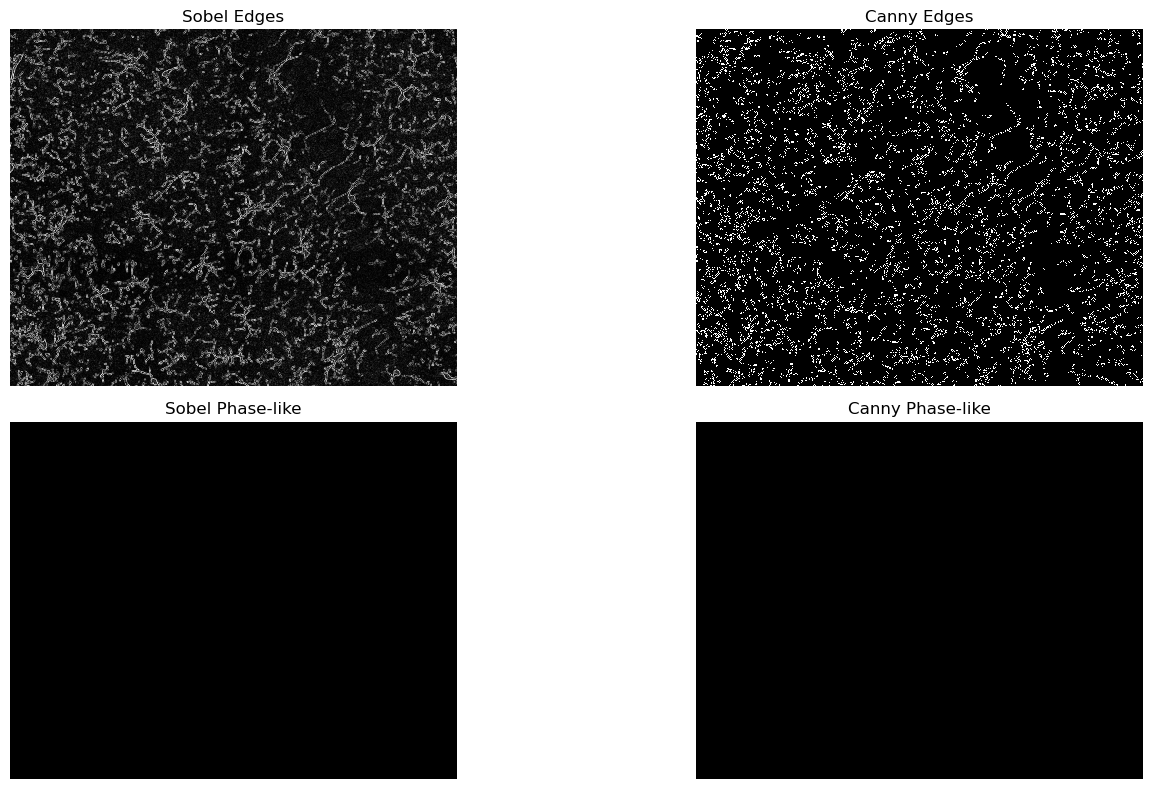

In [9]:
from scipy import ndimage
from skimage import filters, feature
import cv2

def create_phase_contrast_effect(image, method='sobel', sigma=1.0, alpha=0.3):
    """
    Create phase contrast-like effect using edge detection.
    
    Parameters:
    - image: input image
    - method: 'sobel', 'canny', 'laplacian', or 'scharr'
    - sigma: gaussian blur sigma for preprocessing
    - alpha: blending factor for combining original with edges
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Apply slight gaussian blur to reduce noise
    if sigma > 0:
        gray_blurred = filters.gaussian(gray, sigma=sigma)
    else:
        gray_blurred = gray
    
    # Apply edge detection based on method
    if method == 'sobel':
        edges = filters.sobel(gray_blurred)
    elif method == 'canny':
        edges = feature.canny(gray_blurred, sigma=sigma)
        edges = edges.astype(float)
    elif method == 'laplacian':
        edges = filters.laplacian(gray_blurred)
        edges = np.abs(edges)  # Take absolute value
    elif method == 'scharr':
        edges = filters.scharr(gray_blurred)
    else:
        raise ValueError("Method must be 'sobel', 'canny', 'laplacian', or 'scharr'")
    
    # Normalize edges to 0-1 range
    if edges.max() > 0:
        edges = edges / edges.max()
    
    # Create phase contrast effect by combining original with inverted edges
    # Phase contrast shows edges as dark/bright halos
    phase_contrast = gray_blurred - alpha * edges * 255
    
    # Ensure values stay in valid range
    phase_contrast = np.clip(phase_contrast, 0, 255).astype(np.uint8)
    
    return phase_contrast, edges

# Test different edge detection methods
methods = ['sobel', 'canny']

# Use the fixed image for phase contrast
test_img = img_fixed[:,:,0] if len(img_fixed.shape) == 3 else img_fixed

fig, axes = plt.subplots(2, len(methods), figsize=(16, 8))

for i, method in enumerate(methods):
    phase_img, edges = create_phase_contrast_effect(test_img, method=method, sigma=1.0, alpha=0.5)
    
    # Show edges
    axes[0, i].imshow(edges, cmap='gray')
    axes[0, i].set_title(f'{method.capitalize()} Edges')
    axes[0, i].axis('off')
    
    # Show phase contrast effect
    axes[1, i].imshow(phase_img, cmap='gray')
    axes[1, i].set_title(f'{method.capitalize()} Phase-like')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Running cellpose on phase contrast-like image...


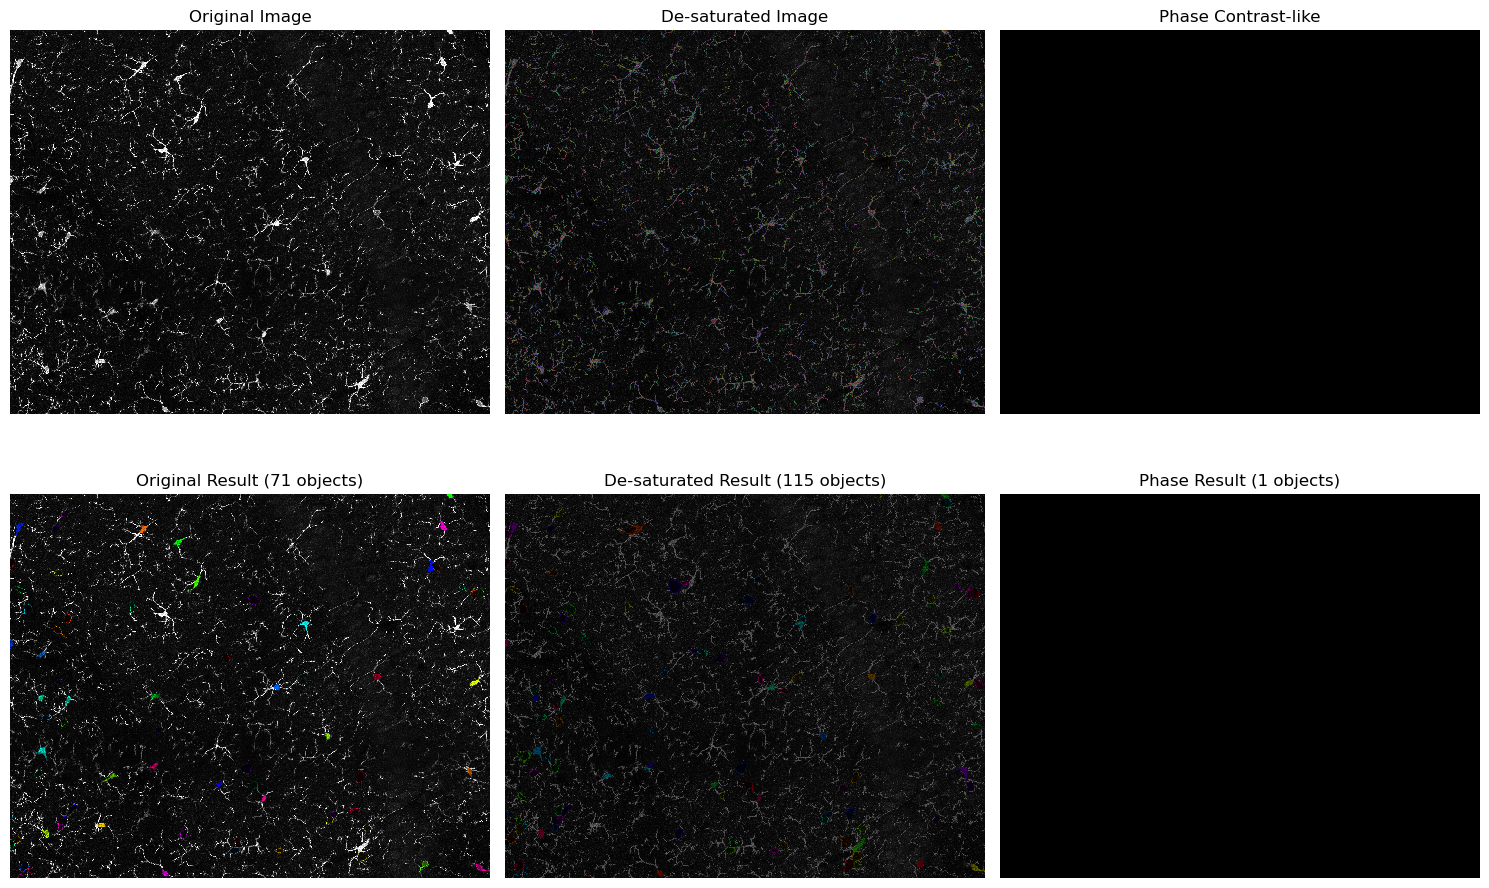


Comparison Summary:
Original: 70 objects detected
De-saturated: 114 objects detected
Phase contrast-like: 0 objects detected


In [10]:
# Create best phase contrast version and test with cellpose
# Choose sobel method as it often works well for phase contrast simulation
phase_contrast_img, _ = create_phase_contrast_effect(test_img, method='sobel', sigma=1.5, alpha=0.4)

# Convert back to 3-channel for cellpose
phase_contrast_3ch = np.stack([phase_contrast_img, phase_contrast_img, phase_contrast_img], axis=2)

print("Running cellpose on phase contrast-like image...")
result_phase = model.eval(phase_contrast_3ch, niter=200)

# Compare all three approaches
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original
axes[0,0].imshow(img_original)
axes[0,0].set_title('Original Image')
axes[0,0].axis('off')

original_overlay = mask_overlay(img_original, result[0])
axes[1,0].imshow(original_overlay)
axes[1,0].set_title(f'Original Result ({len(np.unique(result[0]))} objects)')
axes[1,0].axis('off')

# De-saturated
axes[0,1].imshow(img_fixed)
axes[0,1].set_title('De-saturated Image')
axes[0,1].axis('off')

fixed_overlay = mask_overlay(img_fixed, result_fixed[0])
axes[1,1].imshow(fixed_overlay)
axes[1,1].set_title(f'De-saturated Result ({len(np.unique(result_fixed[0]))} objects)')
axes[1,1].axis('off')

# Phase contrast
axes[0,2].imshow(phase_contrast_img, cmap='gray')
axes[0,2].set_title('Phase Contrast-like')
axes[0,2].axis('off')

phase_overlay = mask_overlay(phase_contrast_3ch, result_phase[0])
axes[1,2].imshow(phase_overlay)
axes[1,2].set_title(f'Phase Result ({len(np.unique(result_phase[0]))} objects)')
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

print("\nComparison Summary:")
print(f"Original: {len(np.unique(result[0]))-1} objects detected")
print(f"De-saturated: {len(np.unique(result_fixed[0]))-1} objects detected") 
print(f"Phase contrast-like: {len(np.unique(result_phase[0]))-1} objects detected")

## Improved phase contrast with directional edges

Create more realistic phase contrast with gray background and directional bright/dark edges.

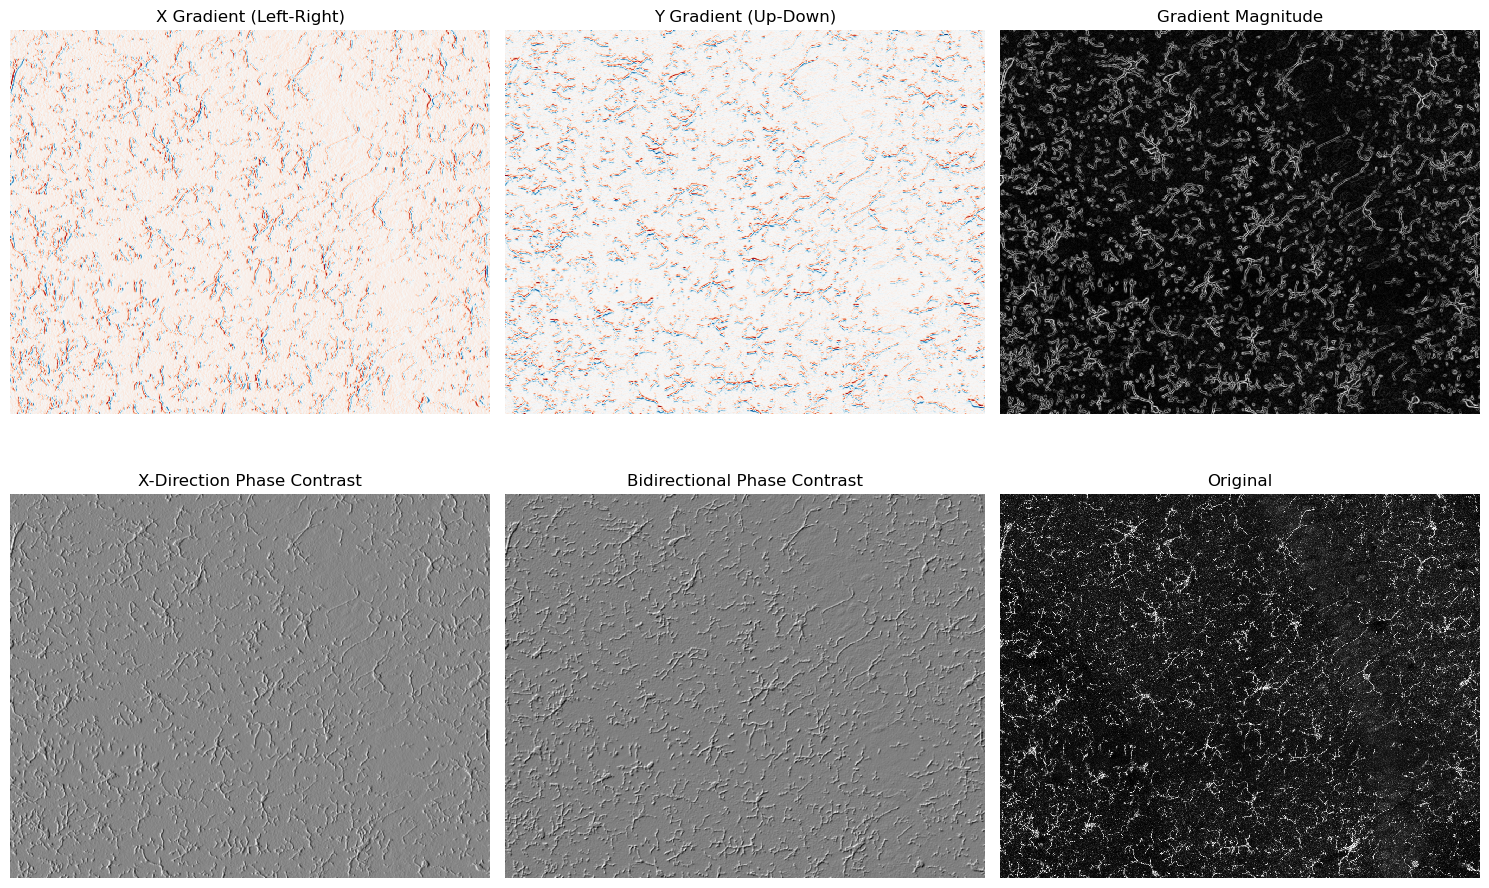

In [11]:
def create_realistic_phase_contrast(image, sigma=1.5, edge_strength=0.6, background_level=128):
    """
    Create realistic phase contrast effect with gray background and directional edges.
    
    Parameters:
    - image: input image
    - sigma: gaussian blur for smoothing
    - edge_strength: strength of edge effect (0.0-1.0)
    - background_level: gray level for background (0-255)
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(float)
    else:
        gray = image.astype(float)
    
    # Apply gaussian smoothing
    gray_smooth = filters.gaussian(gray, sigma=sigma)
    
    # Calculate gradients in X and Y directions
    grad_x = ndimage.sobel(gray_smooth, axis=1)  # horizontal edges
    grad_y = ndimage.sobel(gray_smooth, axis=0)  # vertical edges
    
    # Combine gradients to get directional information
    # Use signed gradients to create bright/dark halos on different sides
    gradient_mag = np.sqrt(grad_x**2 + grad_y**2)
    
    # Create directional phase effect
    # Use gradient_x for creating left-right bright/dark pattern
    directional_effect = grad_x * edge_strength
    
    # Start with gray background
    phase_contrast = np.full_like(gray, background_level, dtype=float)
    
    # Add the directional gradient effect
    phase_contrast = phase_contrast + directional_effect
    
    # Ensure values stay in valid range
    phase_contrast = np.clip(phase_contrast, 0, 255).astype(np.uint8)
    
    return phase_contrast, grad_x, grad_y, gradient_mag

def create_bidirectional_phase_contrast(image, sigma=1.5, edge_strength=0.8, background_level=128):
    """
    Create phase contrast with both X and Y directional effects combined.
    """
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(float)
    else:
        gray = image.astype(float)
    
    gray_smooth = filters.gaussian(gray, sigma=sigma)
    
    # Calculate gradients
    grad_x = ndimage.sobel(gray_smooth, axis=1)
    grad_y = ndimage.sobel(gray_smooth, axis=0)
    
    # Combine both directional effects
    # This creates a more complex halo pattern around edges
    combined_effect = (grad_x + grad_y) * edge_strength * 0.5
    
    # Start with gray background
    phase_contrast = np.full_like(gray, background_level, dtype=float)
    phase_contrast = phase_contrast + combined_effect
    
    phase_contrast = np.clip(phase_contrast, 0, 255).astype(np.uint8)
    
    return phase_contrast

# Test different phase contrast approaches
test_img = img_fixed[:,:,0] if len(img_fixed.shape) == 3 else img_fixed

# Create different versions
phase_x, grad_x, grad_y, grad_mag = create_realistic_phase_contrast(test_img, sigma=1.5, edge_strength=0.6)
phase_bidirectional = create_bidirectional_phase_contrast(test_img, sigma=1.5, edge_strength=0.8)

# Show the gradients and results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Top row: gradients
axes[0,0].imshow(grad_x, cmap='RdBu_r')
axes[0,0].set_title('X Gradient (Left-Right)')
axes[0,0].axis('off')

axes[0,1].imshow(grad_y, cmap='RdBu_r')
axes[0,1].set_title('Y Gradient (Up-Down)')
axes[0,1].axis('off')

axes[0,2].imshow(grad_mag, cmap='gray')
axes[0,2].set_title('Gradient Magnitude')
axes[0,2].axis('off')

# Bottom row: phase contrast results
axes[1,0].imshow(phase_x, cmap='gray')
axes[1,0].set_title('X-Direction Phase Contrast')
axes[1,0].axis('off')

axes[1,1].imshow(phase_bidirectional, cmap='gray')
axes[1,1].set_title('Bidirectional Phase Contrast')
axes[1,1].axis('off')

axes[1,2].imshow(test_img, cmap='gray')
axes[1,2].set_title('Original')
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

Running cellpose on realistic phase contrast image...


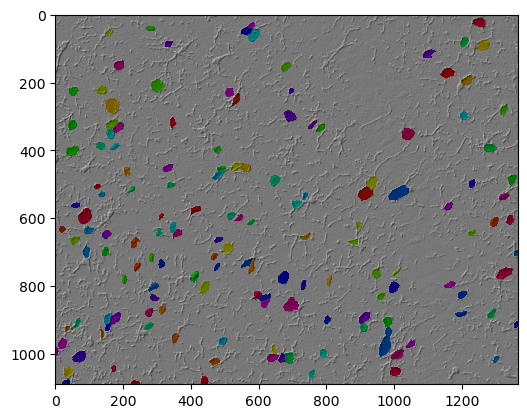

In [12]:
# Test the best version with Cellpose
# Choose bidirectional for more realistic phase contrast appearance
phase_realistic = create_bidirectional_phase_contrast(test_img, sigma=1.5, edge_strength=0.7, background_level=120)

# Convert to 3-channel for cellpose
phase_realistic_3ch = np.stack([phase_realistic, phase_realistic, phase_realistic], axis=2)

print("Running cellpose on realistic phase contrast image...")
result_realistic_phase = model.eval(phase_realistic_3ch, niter=200)

overlay = mask_overlay(phase_realistic_3ch, result_realistic_phase[0])

plt.imshow(overlay)